In [1]:
import json
from string import digits

import numpy as np
import pandas as pd

from keras.datasets import reuters
from keras.models import Model
from keras.layers import Input, Embedding, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import model_to_dot
from keras.losses import cosine_proximity

from seq2seq import SimpleSeq2Seq

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import NearestNeighbors

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG

%matplotlib inline

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True
matplotlib.rcParams["figure.figsize"] = (10, 8)
matplotlib.rcParams["grid.linestyle"] = "dashed"

# Load data

In [3]:
with open("./conversations.corpus.json") as f:
    data = json.load(f)

# Splitting

In [4]:
X = []
y = []
for conversation in data["conversations"]:
    for i in range(len(conversation) - 1):
        
        question = conversation[i]
        answer = conversation[i + 1]
        
        X.append(question)
        y.append(answer)

# Tokenization

In [5]:
filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' + digits
tk = Tokenizer(filters=filters)

In [6]:
tk.fit_on_texts(X + y)

In [7]:
number_of_words = len(tk.word_counts)
print(number_of_words, "unique words")

234 unique words


In [8]:
X_tokenized = tk.texts_to_sequences(X)
y_tokenized = tk.texts_to_sequences(y)

# Padding

In [9]:
lenghts = np.array(list(map(lambda x: len(x), X_tokenized + y_tokenized)))

In [10]:
MAX_SEQUENCE_LENGTH = np.max(lenghts)
MEAN_SEQUENCE_LENGTH = np.mean(lenghts)
print("Maximum sentence length:", MAX_SEQUENCE_LENGTH)
print("Mean sentence length:", np.round(MEAN_SEQUENCE_LENGTH, 2))
print("95% percentile of sentence lengths:", np.round(np.percentile(lenghts, 95), 2))

Maximum sentence length: 27
Mean sentence length: 5.93
95% percentile of sentence lengths: 12.45


In [11]:
MAX_SEQUENCE_LENGTH = 20

In [12]:
X_padded = pad_sequences(X_tokenized, maxlen=MAX_SEQUENCE_LENGTH)
y_padded = pad_sequences(y_tokenized, maxlen=MAX_SEQUENCE_LENGTH)

# Embedding

In [13]:
embeddings_index = {}
f = open("./wiki_w2v.vec")
f.readline()
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [14]:
EMBEDDING_DIM = len(embeddings_index["the"])
print("Embedding dimension is", EMBEDDING_DIM)

Embedding dimension is 100


Select only those word-vectors from pre-trained model that are in our vocabulary

In [15]:
embedding_matrix = np.zeros((number_of_words + 1, EMBEDDING_DIM))
for word, i in tk.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Train/test split

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X_padded, y_padded, 
                                                      random_state=21, 
                                                      test_size=0.2)

# Architecture

In [17]:
inp_data = Input(shape=(MAX_SEQUENCE_LENGTH,), 
                 dtype=np.int32, 
                 name="input_data")

In [18]:
emb_data = Embedding(input_dim=number_of_words + 1,
                     output_dim=EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False,
                     mask_zero=False, 
                     name="embedded_data")(inp_data)

In [19]:
inp_labels = Input(shape=(MAX_SEQUENCE_LENGTH,), 
                   dtype=np.int32, 
                   name="input_labels")

In [20]:
emb_labels = Embedding(input_dim=number_of_words + 1,
                       output_dim=EMBEDDING_DIM,
                       weights=[embedding_matrix],
                       input_length=MAX_SEQUENCE_LENGTH,
                       trainable=False, 
                       mask_zero=False, 
                       name="embedded_labels")(inp_labels)

In [21]:
encdec = SimpleSeq2Seq(output_dim=EMBEDDING_DIM, 
                       output_length=MAX_SEQUENCE_LENGTH, 
                       hidden_dim=128, 
                       input_dim=EMBEDDING_DIM, 
                       input_length=MAX_SEQUENCE_LENGTH)(emb_data)

In [22]:
loss = Lambda(function=lambda args: cosine_proximity(*args), 
              output_shape=(1,), 
              name="cosine_proximity")([emb_labels, encdec])

In [23]:
model = Model(inputs=[inp_data, inp_labels], outputs=[loss])

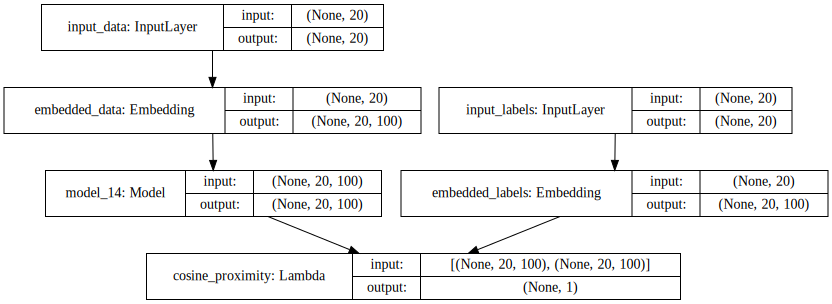

In [24]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [25]:
model.compile(loss={"cosine_proximity": lambda y_true, y_pred: y_pred}, 
              optimizer="adam")

In [26]:
model_predictive = Model(inputs=[inp_data], outputs=[encdec])

# Training

In [27]:
train_data = ({"input_data": X_train, 
               "input_labels": y_train}, 
              {"cosine_proximity": np.zeros([X_train.shape[0]])})

In [28]:
valid_data = ({"input_data": X_valid, 
               "input_labels": y_valid}, 
              {"cosine_proximity": np.zeros([X_valid.shape[0]])})

In [29]:
hist = model.fit(*train_data, 
                 epochs=40, 
                 validation_data=valid_data, 
                 verbose=0)

/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


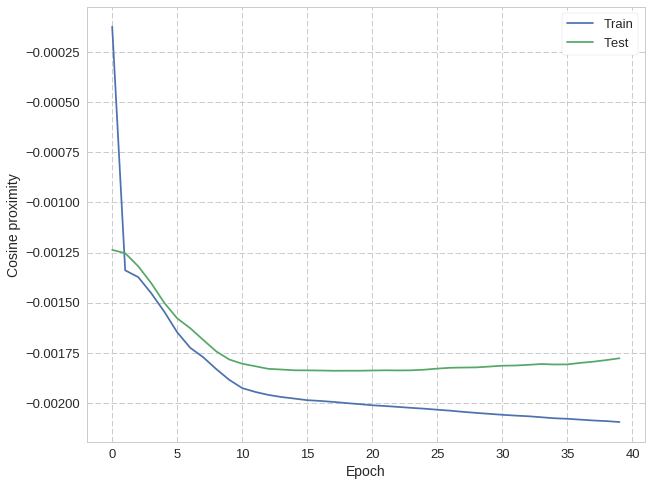

In [30]:
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Test")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Cosine proximity", fontsize=14)
plt.legend();

In [31]:
preds = model_predictive.predict(X_valid)

/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


# Reconstruct answers

In [32]:
class Embeddings(object):
    
    def __init__(self, embedding_dict):
        """
        Implements simple routine to work with word vector
        using pre-trained embedding and sklearn nearest
        neighbors module
        
        Args:
            embedding_dict(dict): words as keys and vectors as values

        Return:
            self
        """
        # initialize word and vector arrays
        self.words = np.array(list(embedding_dict.keys()))
        self.vectors = np.array(list(embedding_dict.values()))
        # fir nearest neighbors model with cosine similatiry between word-vectors
        self._nn = NearestNeighbors(metric="cosine", n_jobs=1, algorithm="brute")
        self._nn.fit(self.vectors)
        
    def get_vector(self, word):
        """
        Return the word-vector for given word if it is in the vocabulary
        
        Args:
            word(str): word to look up for
            
        Return:
            vector(ndarray): vector for given word
        """
        
        assert (word in self.words), "Word is not in the vocabulary"
        word_idx = np.where(self.words == word)[0]
        return self.vectors[word_idx]
            
    def closest(self, word, n_closest=1, include_itself=True):
        """
        Find the closest word in the vocabulary to the given data
        
        Args:
            word(str or ndarray): if str then the corresponding
                                  vector will be retrieved first;
                                  ndarray will be treated as a
                                  word-vector
            n_closest(int): number of closest words to return
            include_itself(bool): whether to include the vector
                                  itself if it is in the vocabulary
                                  
        Return:
            words(ndarray of str): array with closest words
        """
        # check which input do we have
        if type(word) is str:
            word_vector = self.get_vector(word)
        else:
            word_vector = word
        # distinguish between returning itself and not
        if include_itself:
            closest_idxs = self._nn.kneighbors(word_vector, n_neighbors=n_closest)
            return self.words[closest_idxs[1][0]]
        else:
            closest_idxs = self._nn.kneighbors(word_vector, n_neighbors=n_closest + 1)
            return self.words[closest_idxs[1][0][1:]]

In [33]:
restricted_dict = dict(list(zip(["NULL"] + list(tk.word_index.keys()), embedding_matrix)))

In [34]:
w2v = Embeddings(restricted_dict)

In [35]:
inv_word_index = {v: k for k, v in tk.word_index.items()}
inv_word_index[0] = "NULL"

In [36]:
pred_text = []
true_text = []
for sentence_idx in range(len(preds)):
    pred = []
    true = []
    for word_idx in range(len(preds[sentence_idx])):
        pred.append(w2v.closest([preds[sentence_idx][word_idx]])[0])
        true.append(inv_word_index[y_valid[sentence_idx][word_idx]])
    pred_text.append(pred)
    true_text.append(true)

## Comparison of answers

In [37]:
idx = 0
print("True text:\n", true_text[idx])
print("Pred text:\n", pred_text[idx])

True text:
 ['NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'what', 'else', 'is', 'delicious']
Pred text:
 ['so', 'anyway', 'anyway', 'anyway', 'anyway', 'anyway', 'anyway', 'anyway', 'anyway', 'anyway', 'anyway', 'anyway', 'anyway', 'anyway', 'anyway', 'anyway', 'anyway', 'anyway', 'anyway', 'anyway']
